In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


In [176]:
df = pd.read_csv("Sunspots.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df.drop(index=df[df["Monthly Mean Total Sunspot Number"] == 0].index, inplace=True)
df.columns = ["Date", "Sunspot"]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.head())
print(df.describe())
print(df.isnull().sum())


            Sunspot
Date               
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
           Sunspot
count  3198.000000
mean     83.492089
std      67.545921
min       0.200000
25%      26.200000
50%      70.050000
75%     124.150000
max     398.200000
Sunspot    0
dtype: int64


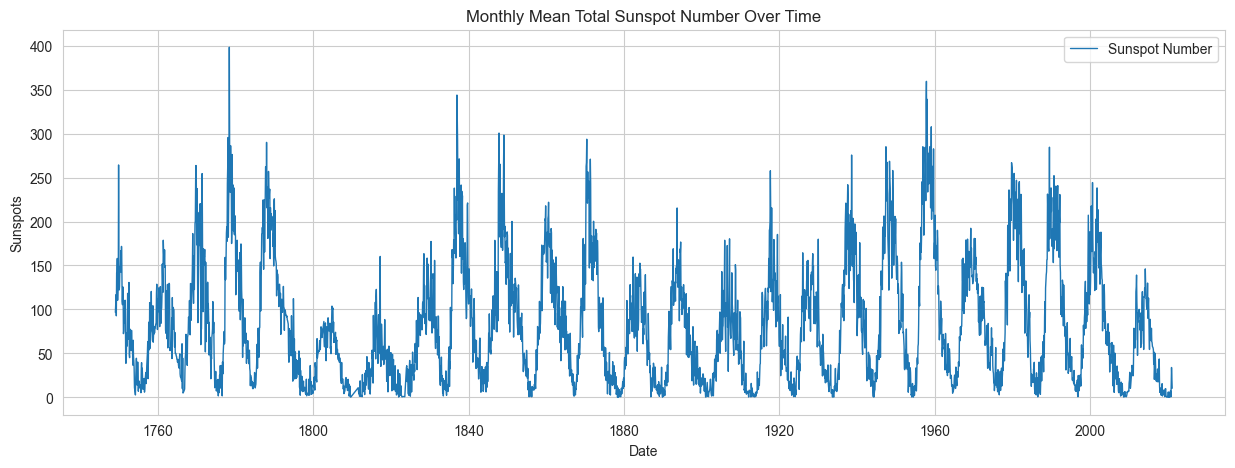

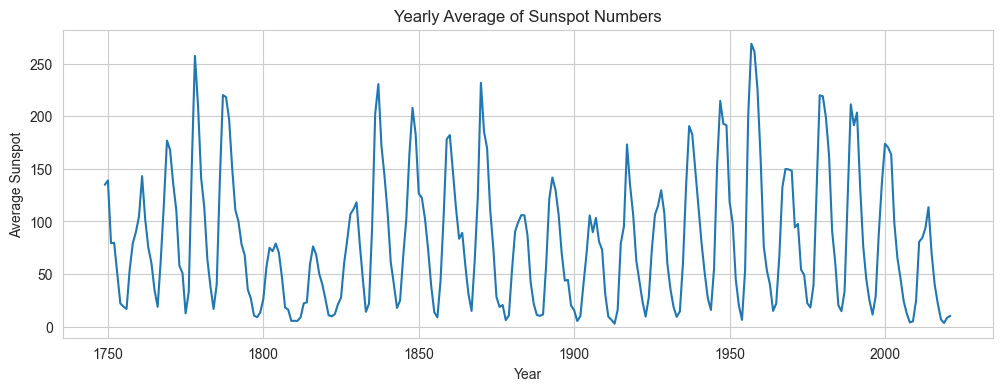

In [177]:

plt.figure(figsize=(15,5))
plt.plot(df.index, df["Sunspot"], label="Sunspot Number", linewidth=1)
plt.title("Monthly Mean Total Sunspot Number Over Time")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.legend()
plt.grid(True)
plt.show()


df['Year'] = df.index.year
yearly_avg = df.groupby("Year")["Sunspot"].mean()

plt.figure(figsize=(12,4))
yearly_avg.plot()
plt.title("Yearly Average of Sunspot Numbers")
plt.ylabel("Average Sunspot")
plt.grid(True)
plt.show()


In [178]:
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)


df['Sunspot_lag1'] = df['Sunspot'].shift(1)
df['Sunspot_lag12'] = df['Sunspot'].shift(12)
df['Sunspot_lag60'] = df['Sunspot'].shift(60)


df['Diff_11Year'] = df['Sunspot'] - df['Sunspot'].shift(132)

df["Year_frac"] = df.index.year + (df.index.month - 1)/12
df["Year_sin"] = np.sin(2 * np.pi * df["Year_frac"] / 11)  
df["Year_cos"] = np.cos(2 * np.pi * df["Year_frac"] / 11)


df['Rolling_11Yr'] = df['Sunspot'].rolling(window=132, min_periods=1).mean()
df['rolling_mean_12'] = df['Sunspot'].rolling(window=12).mean()
df['rolling_std_12'] = df['Sunspot'].rolling(window=12).std()


df.dropna(inplace=True)


In [179]:
features = ['Month_sin', 'Month_cos', 'Sunspot_lag1', 'Sunspot_lag12',  'rolling_mean_12', 'rolling_std_12','Diff_11Year','Rolling_11Yr',"Year_frac","Year_sin","Year_cos","Sunspot_lag60"]
target = 'Sunspot'

X = df[features]
y = df[target]

X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)


In [180]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


In [181]:
model = LGBMRegressor()
model.fit(X_train, y_train_full)

y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 12
[LightGBM] [Info] Start training from score 79.487372


In [182]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "R2": r2}

print("Test Set:")
print(evaluate(y_test, y_pred_test))

print("Validation Set:")
print(evaluate(y_val, y_pred_val))


Test Set:
{'RMSE': np.float64(25.054357544406248), 'R2': 0.9058784061840753}
Validation Set:
{'RMSE': np.float64(16.394257924814358), 'R2': 0.9373423793634839}


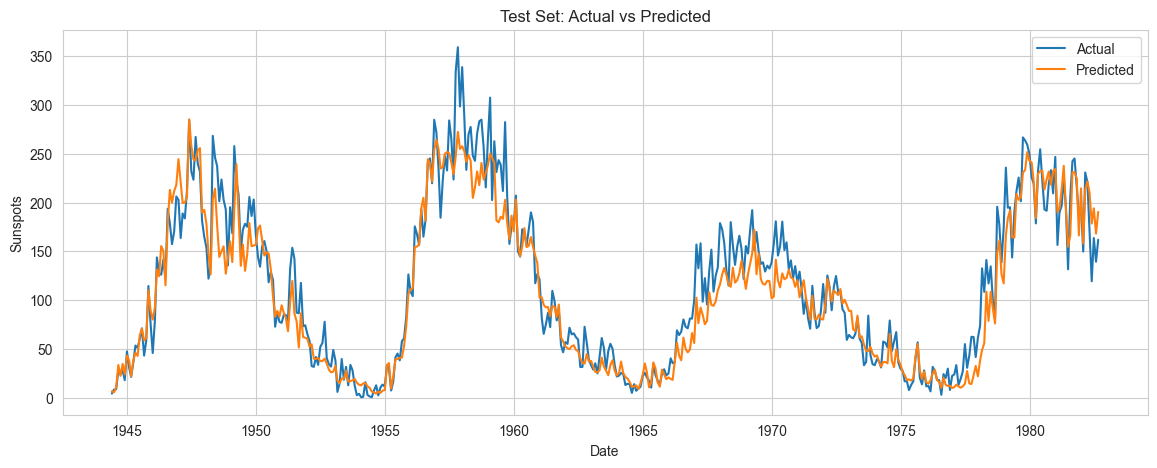

In [183]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_test, label='Predicted', linestyle='-')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.legend()
plt.grid(True)
plt.show()


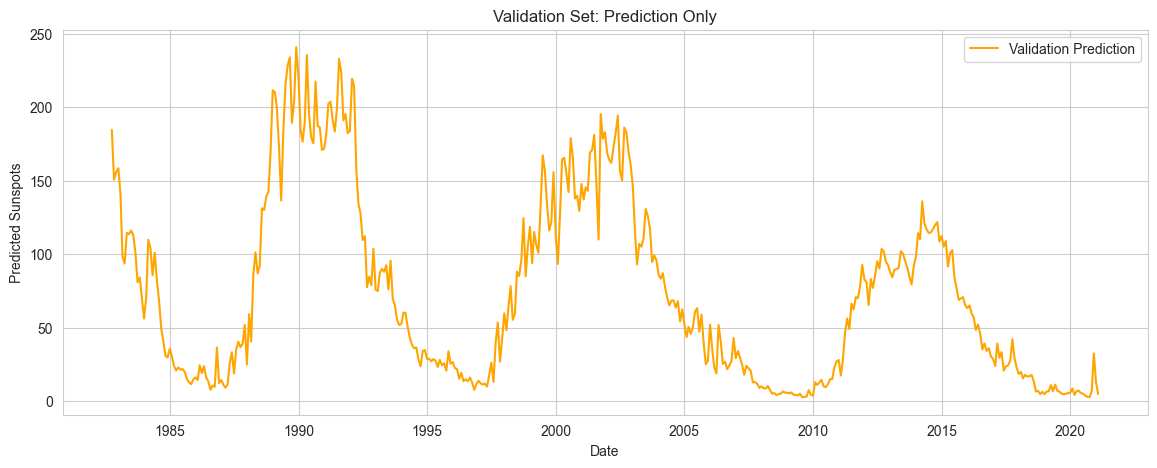

In [184]:
plt.figure(figsize=(14, 5))
plt.plot(y_val.index, y_pred_val, label='Validation Prediction', color='orange')
plt.title("Validation Set: Prediction Only")
plt.xlabel("Date")
plt.ylabel("Predicted Sunspots")
plt.legend()
plt.grid(True)
plt.show()


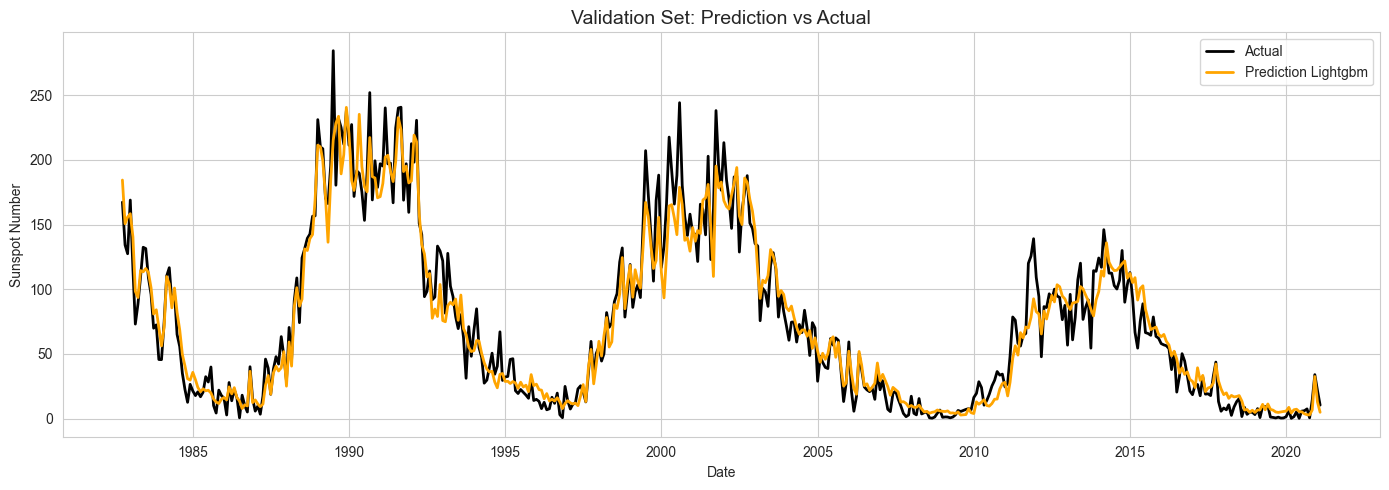

In [185]:
plt.figure(figsize=(14, 5))


plt.plot(y_val.index, y_val, label='Actual', color='black', linewidth=2)


plt.plot(y_val.index, y_pred_val, label='Prediction Lightgbm', color='orange', linestyle='-', linewidth=2)

plt.title("Validation Set: Prediction vs Actual", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


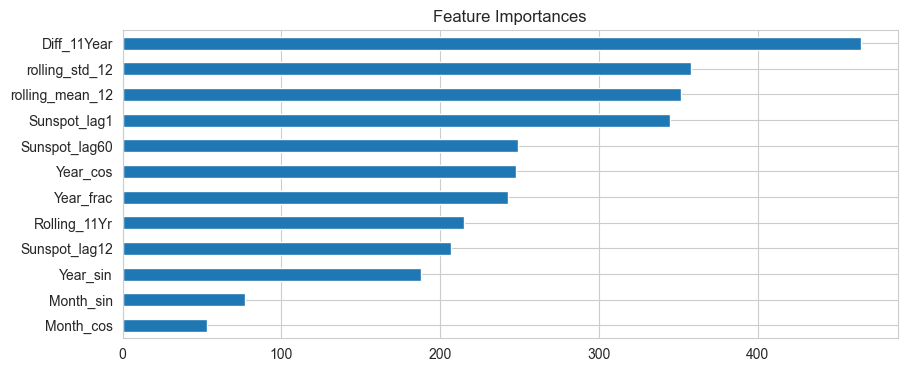

In [186]:
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(10, 4), title="Feature Importances")
plt.grid(True)
plt.show()


In [187]:

print("🔸 Test Set Predictions:")
test_preds = pd.DataFrame({
    "Date": y_test.index,
    "Actual": y_test.values,
    "Predicted": y_pred_test
})
print(test_preds.tail(10))  


print("\n🔸 Validation Set Predictions (Only Predictions shown):")
val_preds = pd.DataFrame({
    "Date": y_val.index,
    "Predicted": y_pred_val
})
print(val_preds.tail(10))  


🔸 Test Set Predictions:
          Date  Actual   Predicted
450 1981-11-30   186.0  166.354216
451 1981-12-31   195.4  214.625609
452 1982-01-31   149.8  158.037855
453 1982-02-28   230.9  213.472931
454 1982-03-31   221.1  221.718960
455 1982-04-30   170.3  210.313289
456 1982-05-31   119.3  178.602771
457 1982-06-30   163.7  194.145011
458 1982-07-31   139.4  168.237018
459 1982-08-31   161.9  190.504211

🔸 Validation Set Predictions (Only Predictions shown):
          Date  Predicted
450 2020-04-30   7.251695
451 2020-05-31   5.458752
452 2020-06-30   5.228668
453 2020-07-31   3.741590
454 2020-08-31   3.024258
455 2020-09-30   2.845593
456 2020-10-31   6.691292
457 2020-11-30  32.533154
458 2020-12-31  12.858099
459 2021-01-31   4.887067


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 12
[LightGBM] [Info] Start training from score 79.487372


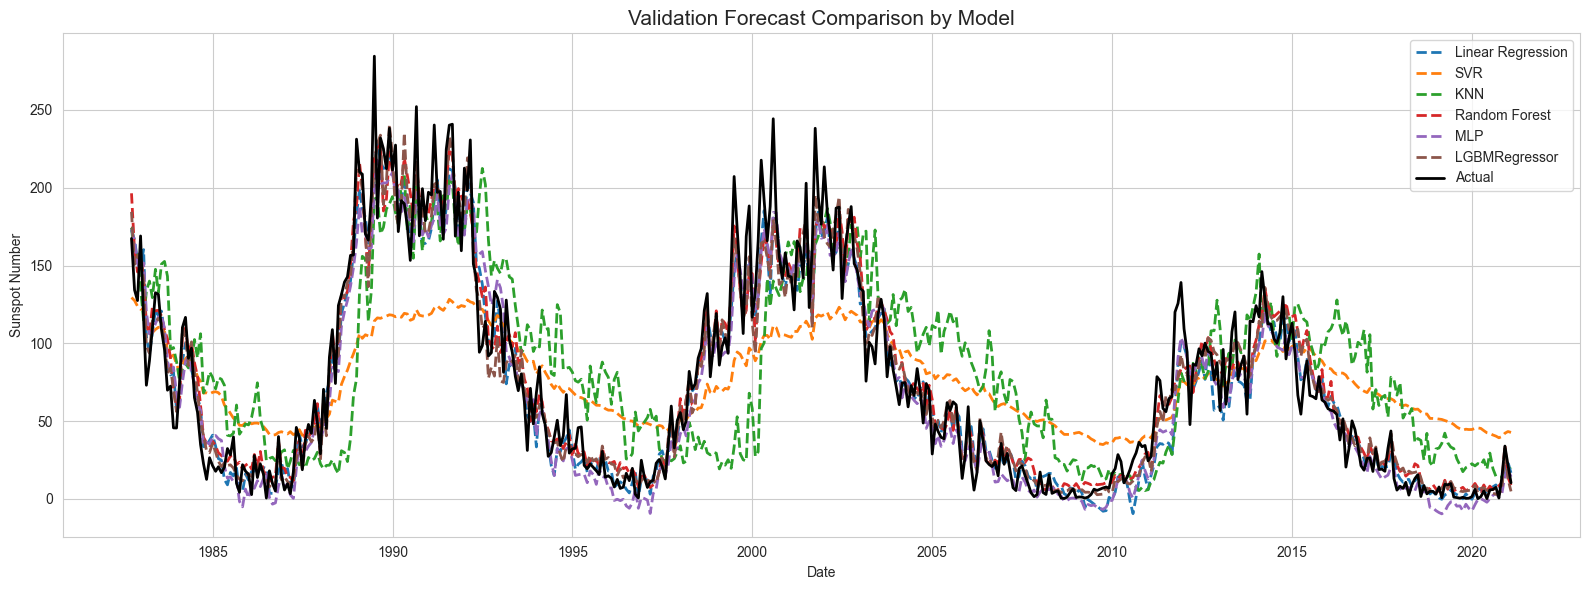

In [188]:





models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(),
    "MLP": MLPRegressor(),
    "LGBMRegressor":LGBMRegressor()
}

val_preds = pd.DataFrame(index=y_val.index)
val_preds["Actual"] = y_val

for name, model in models.items():
    model.fit(X_train, y_train_full)
    val_preds[name] = model.predict(X_val)


plt.figure(figsize=(16, 6))
sns.set_style("whitegrid")

for name in val_preds.columns[1:]:
    plt.plot(val_preds.index, val_preds[name], label=name, linestyle='--', linewidth=2)

plt.plot(val_preds.index, val_preds["Actual"], label="Actual", color="black", linewidth=2)

plt.title("Validation Forecast Comparison by Model", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


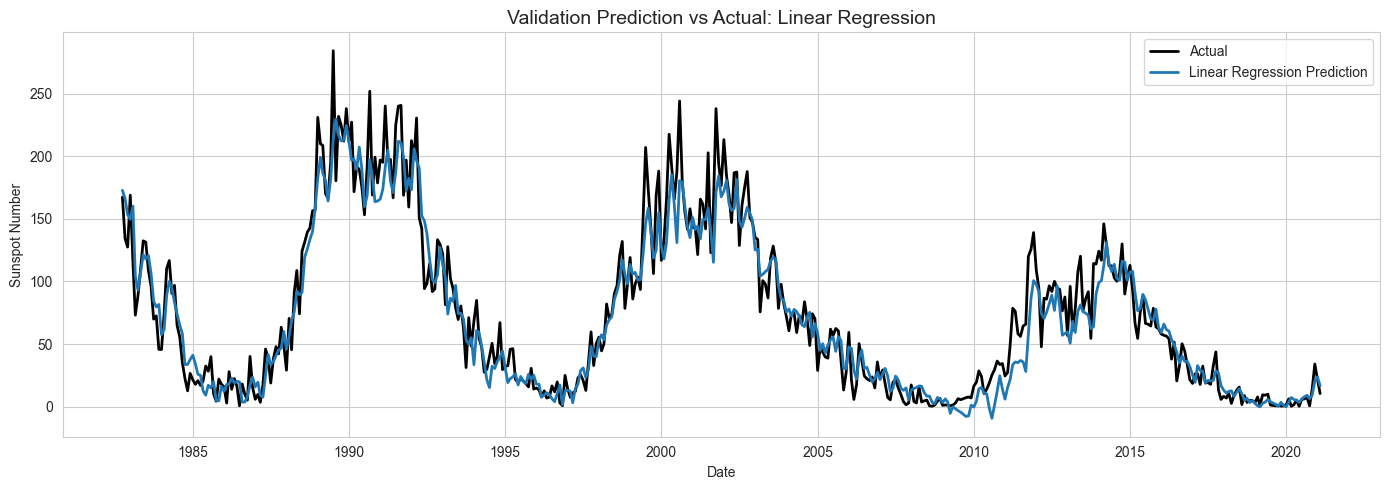

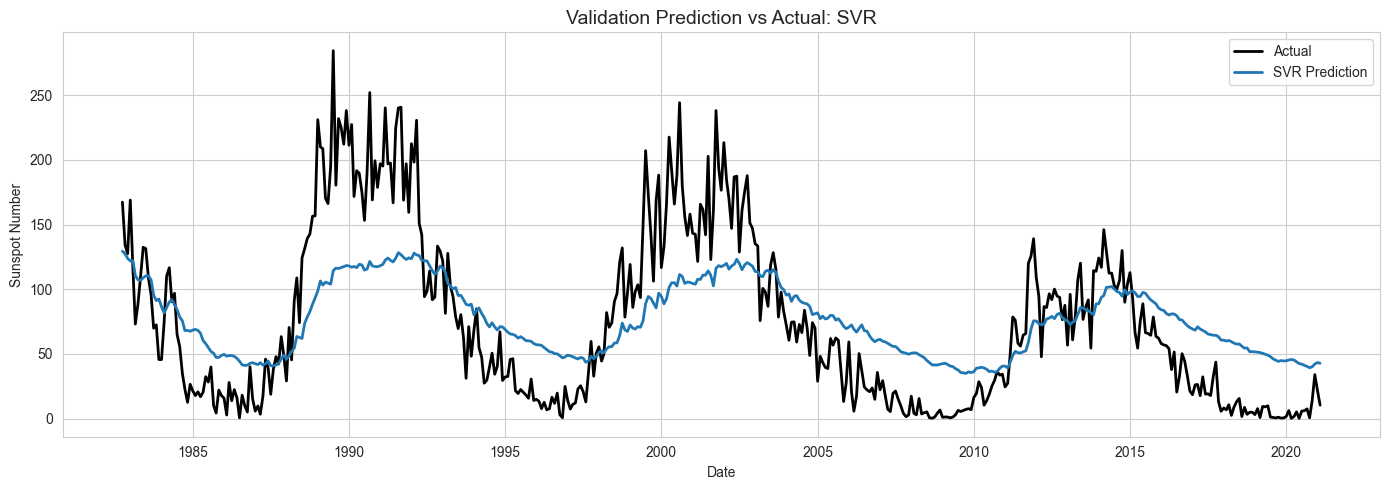

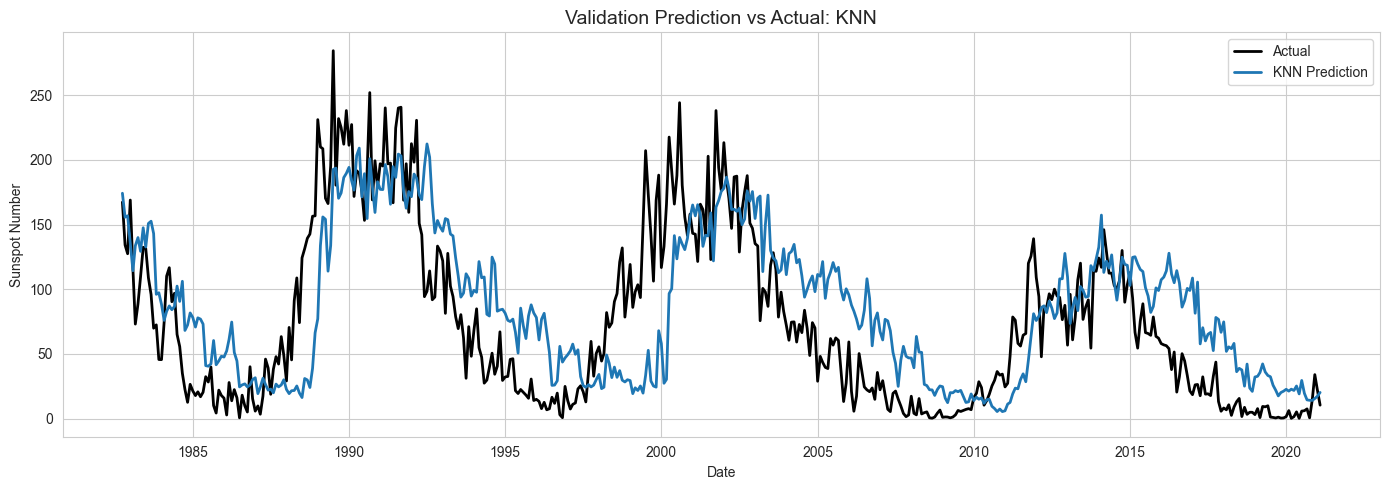

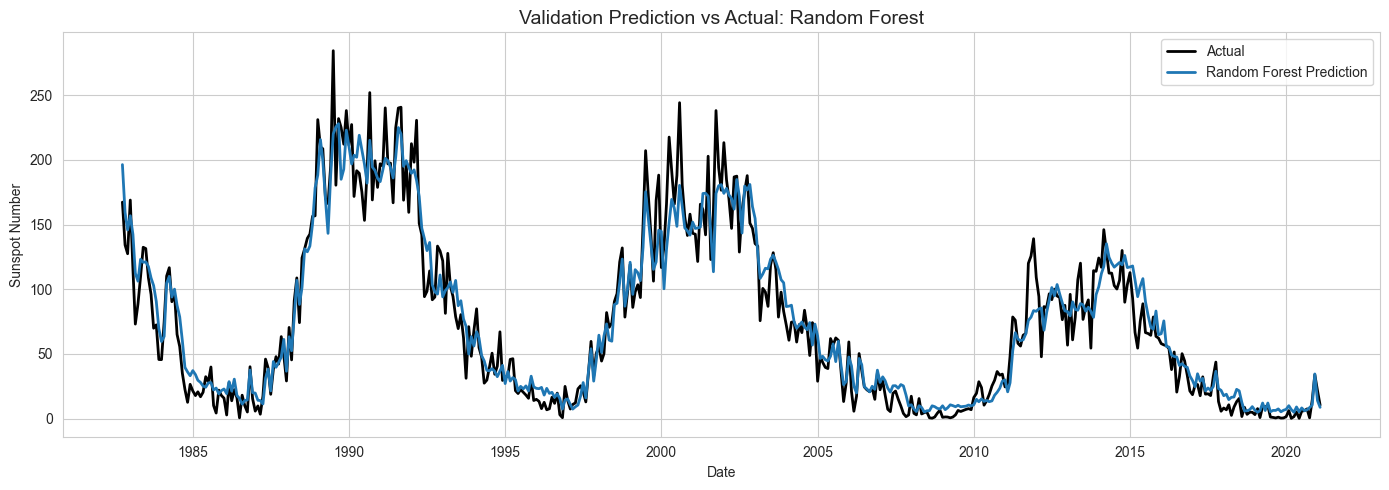

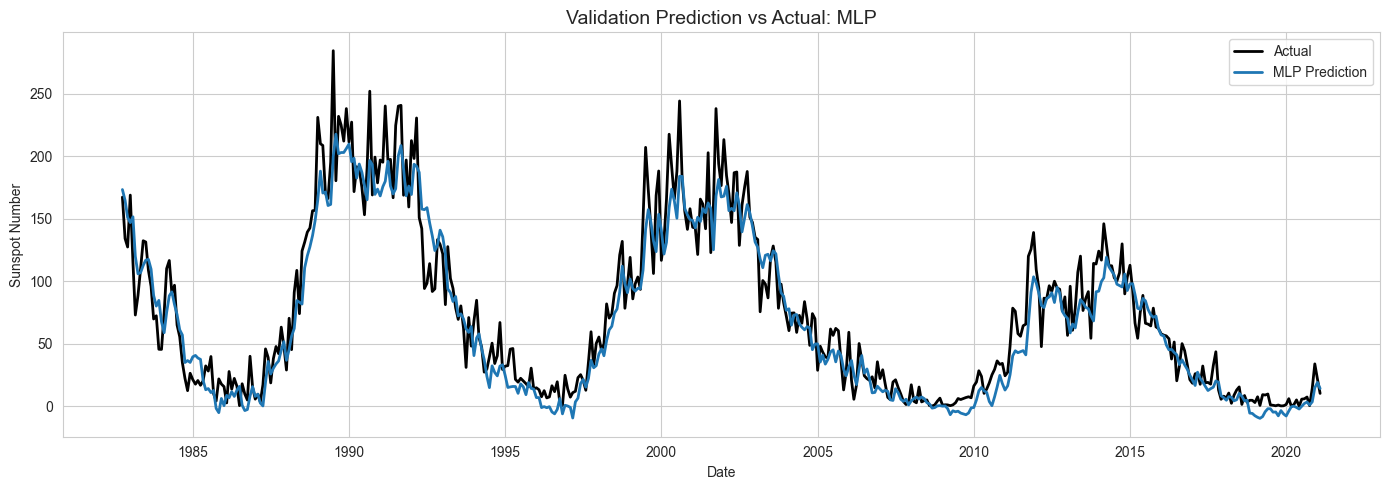

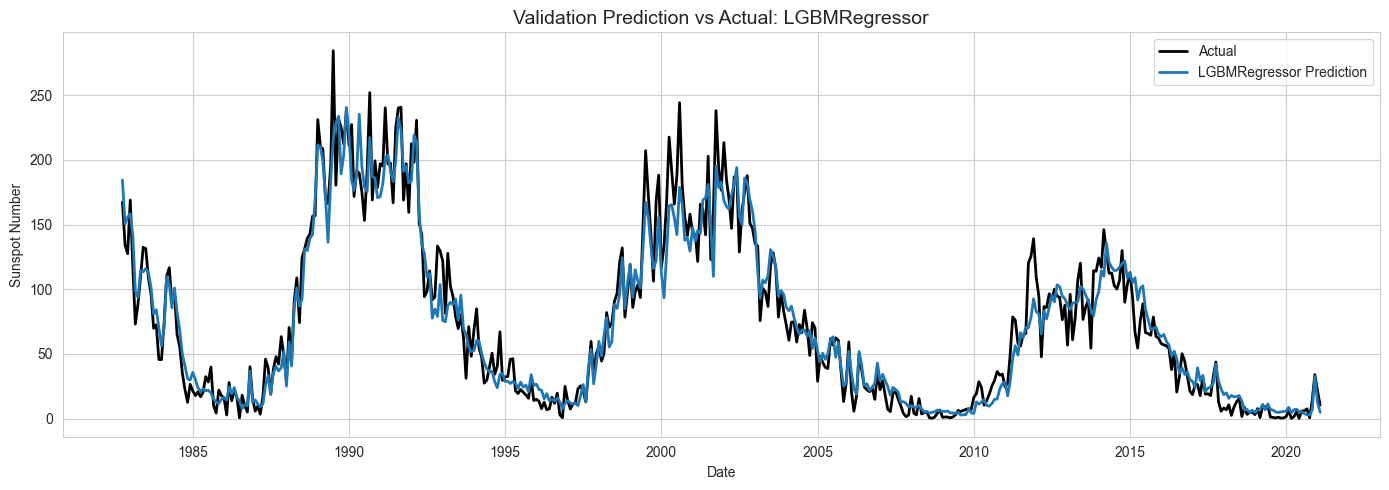

In [189]:
import matplotlib.pyplot as plt

for name in val_preds.columns[1:]:  
    plt.figure(figsize=(14, 5))
    
    
    plt.plot(val_preds.index, val_preds["Actual"], label="Actual", color="black", linewidth=2)
    
    
    plt.plot(val_preds.index, val_preds[name], label=f"{name} Prediction", linestyle='-', linewidth=2)
    
    plt.title(f"Validation Prediction vs Actual: {name}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [190]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

rmse_scores = []


for model_name in val_preds.columns[1:]:
    rmse = np.sqrt(mean_squared_error(val_preds["Actual"], val_preds[model_name]))
    rmse_scores.append((model_name, rmse))


rmse_df = pd.DataFrame(rmse_scores, columns=["Model", "RMSE"])
rmse_df = rmse_df.sort_values(by="RMSE")

rmse_df.reset_index(drop=True, inplace=True)
print(rmse_df)


               Model       RMSE
0      LGBMRegressor  16.394258
1      Random Forest  17.560761
2  Linear Regression  18.472777
3                MLP  20.229888
4                SVR  45.244211
5                KNN  48.115910


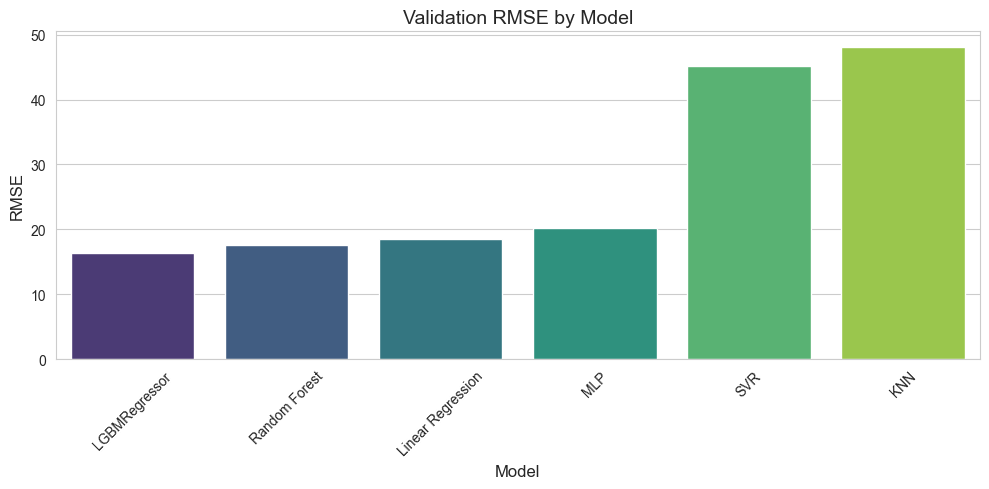

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))


sns.barplot(data=rmse_df, x="Model", y="RMSE", palette="viridis")

plt.title("Validation RMSE by Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [192]:
best_model_name = rmse_df.iloc[0]["Model"]
print(f"Best Model: {best_model_name}")


Best Model: LGBMRegressor


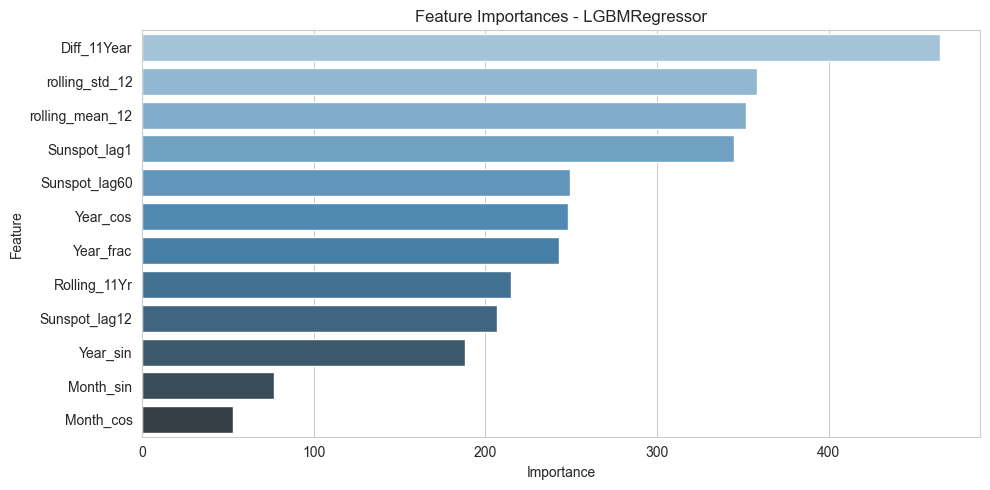

In [193]:

feature_names = X.columns.tolist()



best_model = models[best_model_name]

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    importances = np.abs(best_model.coef_)
else:
    importances = None


if importances is not None:
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="Blues_d")
    plt.title(f"Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()



In [194]:
import plotly.express as px
import plotly.io as pio




val_preds_long = val_preds.reset_index().melt(
    id_vars="Date",
    var_name="Model",
    value_name="Prediction"
)


color_map = {
    "Actual": "black",
    "Linear Regression": "#faf602",  
    "SVR": "#03f72c",                
    "KNN": "purple",                
    "Random Forest": "#00fcfc",      
    "MLP": "#0113b9",
    "LGBMRegressor":"red"                 
}


fig = px.line(
    val_preds_long,
    x="Date",
    y="Prediction",
    color="Model",
    title="Validation Predictions vs Actual (Styled)",
    labels={"Prediction": "Sunspot Number"},
    color_discrete_map=color_map
)


fig.for_each_trace(
    lambda trace: trace.update(line=dict(width=5)) if trace.name == "Actual"
    else trace.update(line=dict(width=2))
)


fig.update_layout(
    template="plotly_white",
    legend_title="Models",
    font=dict(size=14)
)

fig.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 11
[LightGBM] [Info] Start training from score 93.017660


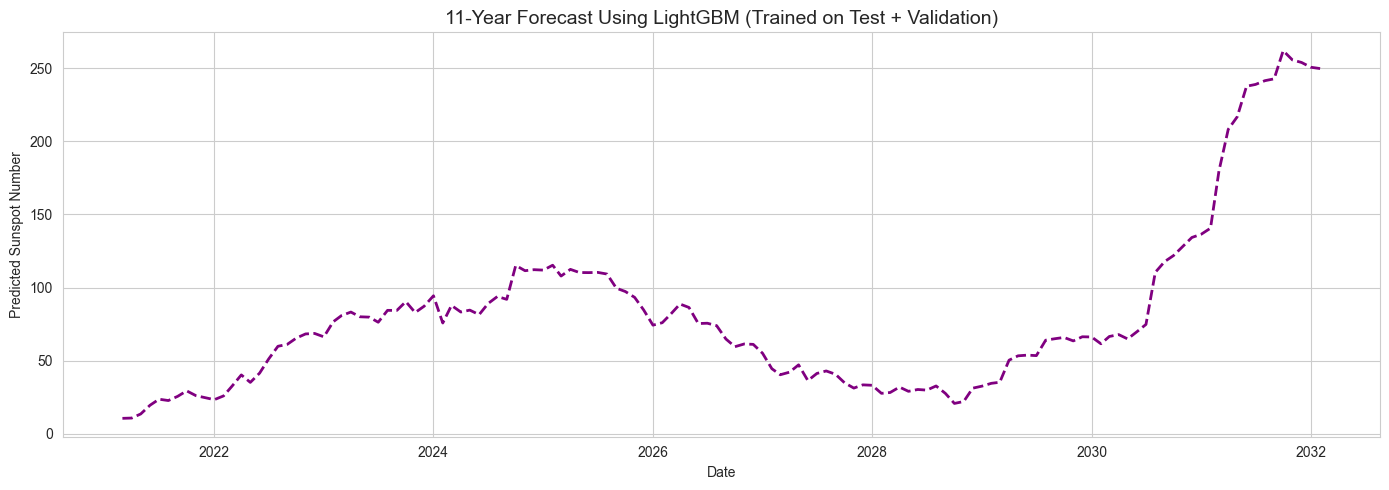

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split


df = pd.read_csv("Sunspots.csv")
df.rename(columns={"Monthly Mean Total Sunspot Number": "Sunspot"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)


df['Month'] = df.index.month
df['Day'] = df.index.day
df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)
df['Sunspot_lag1'] = df['Sunspot'].shift(1)
df['Sunspot_lag12'] = df['Sunspot'].shift(12)
df['Sunspot_lag60'] = df['Sunspot'].shift(60)
df['Diff_11Year'] = df['Sunspot'] - df['Sunspot'].shift(132)
df["Year_frac"] = df.index.year + (df.index.month - 1)/12
df["Year_sin"] = np.sin(2 * np.pi * df["Year_frac"] / 11)
df["Year_cos"] = np.cos(2 * np.pi * df["Year_frac"] / 11)
df['Rolling_11Yr'] = df['Sunspot'].rolling(window=132, min_periods=1).mean()
df['rolling_mean_12'] = df['Sunspot'].rolling(window=12).mean()
df['rolling_std_12'] = df['Sunspot'].rolling(window=12).std()
df.dropna(inplace=True)


features = [
    'Month_sin', 'Month_cos',
    'Sunspot_lag1', 'Sunspot_lag12', 'Sunspot_lag60',
    'Diff_11Year',
    'rolling_mean_12', 'rolling_std_12',
    'Year_sin', 'Year_cos', 'Rolling_11Yr'
]

X = df[features]
y = df["Sunspot"]


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)


X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)


X_future_train = pd.concat([X_test, X_val])
y_future_train = pd.concat([y_test, y_val])


scaler = MinMaxScaler()
X_future_train_scaled = scaler.fit_transform(X_future_train)


model_lgb = lgb.LGBMRegressor(random_state=42)
model_lgb.fit(X_future_train_scaled, y_future_train)


n_future = 132
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future, freq='MS')

future_df = df.copy()
future_preds = []

for date in future_dates:
    month = date.month
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    lag_1 = future_df.iloc[-1]["Sunspot"]
    lag_12 = future_df.iloc[-12]["Sunspot"]
    lag_60 = future_df.iloc[-60]["Sunspot"]
    diff_11y = lag_1 - future_df.iloc[-132]["Sunspot"]
    roll_mean = future_df["Sunspot"].rolling(window=12).mean().iloc[-1]
    roll_std = future_df["Sunspot"].rolling(window=12).std().iloc[-1]
    year_frac = date.year + (date.month - 1)/12
    year_sin = np.sin(2 * np.pi * year_frac / 11)
    year_cos = np.cos(2 * np.pi * year_frac / 11)
    rolling_11yr = future_df["Sunspot"].rolling(window=132).mean().iloc[-1]

    row = pd.DataFrame([[
        month_sin, month_cos, lag_1, lag_12, lag_60,
        diff_11y, roll_mean, roll_std, year_sin, year_cos, rolling_11yr
    ]], columns=features)

    row_scaled = scaler.transform(row)
    pred = model_lgb.predict(row_scaled)[0]
    future_preds.append(pred)

    future_df.loc[date] = {
        'Sunspot': pred,
        'Month': month,
        'Day': 1,
        'Month_sin': month_sin,
        'Month_cos': month_cos,
        'Sunspot_lag1': lag_1,
        'Sunspot_lag12': lag_12,
        'Sunspot_lag60': lag_60,
        'Diff_11Year': diff_11y,
        'rolling_mean_12': roll_mean,
        'rolling_std_12': roll_std,
        'Year_frac': year_frac,
        'Year_sin': year_sin,
        'Year_cos': year_cos,
        'Rolling_11Yr': rolling_11yr
    }


future_forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted": future_preds
}).set_index("Date")

plt.figure(figsize=(14, 5))
plt.plot(future_forecast_df.index, future_forecast_df["Predicted"], color="purple", linestyle="--", linewidth=2)
plt.title("11-Year Forecast Using LightGBM (Trained on Test + Validation)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Predicted Sunspot Number")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

future_forecast_df.to_csv("sunspot_11_year_forecast_lightgbm.csv")
